<a href="https://colab.research.google.com/github/anjisun221/css_codes/blob/main/ay21t1/Lab03_text_analysis/Lab3_text_analysis_national_day_speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Lab 3 - Text-as-Data, National Day Speech analysis

In this lab, you will learn:
* How to clean texts
* How to count words from texts and draw wordcloud from word frequencies
* How to do comparative text analysis by extracting representative words from a corpus using lod-odds analysis

This lab is written by Jisun AN (jisunan@smu.edu.sg) and Michelle KAN (michellekan@smu.edu.sg).


In [ ]:
# Add Google Drive as an accessible path (Optional if you are running from Jupyter Notebook)
from google.colab import drive
drive.mount('/content/drive')

# change path to the designated google drive folder
# otherwise, data will be saved in /content folder which you may have issue locating
%cd /content/drive/My Drive/Colab Notebooks/

In [ ]:
mypath = "."

# 0. import utility functions

#### We've created a few utility functions. 

```read_word_count_file()``` : the input is csv file and the output is dictionary of word counts where the key is word and the value is the frequency of the words. e.g., {'singapore': 6472873} The input file must be a CSV file where each line is a pair of word and its counrt (e.g., singapore, 6472873).  


```read_word_count_file_online()``` : this helps to import the data from online file. The input is url of the csv file and the output is dictionary of word counts where the key is word and the value is the frequency of the words. e.g., {'singapore': 6472873} The input file must be a CSV file where each line is a pair of word and its counrt (e.g., singapore, 6472873).  

In [ ]:
### Let's download ```smt203util.py``` Below code should download the file in the same folder where your jupyter notebook is. 
!wget https://raw.githubusercontent.com/anjisun221/css_codes/main/ay21t1/Lab03_text_analysis/smt203util.py


In [ ]:
### Let's import all function from smt203util! 
from smt203util import *


# 1. Getting the data

In this lab, we will use national day speech data. 

This data is manually annotated by humans according to their aspect and sentiment. 

One review may have two or more aspects and thus two ore more sentiment. 

We note that we excluded those conflicting reviews.

"restaurant_reviews.tsv" is tab-separated file which fields are: 

- `sid` is review id
- `text` is a review
- `aspect` refers to the review area of interest. It consists of any of these five labels: <i>food, service, ambience, price</i> 
- `sentiment` consists of one of these labels: <i>positive, negative, neutral</i>

In [2]:
### Import Pandas to analyze the data
import pandas as pd


In [59]:
### Read the file using Pandas 'read_table' function (either read_table, read_csv is fine)
df = pd.read_table("https://raw.githubusercontent.com/anjisun221/css_codes/main/ay21t1/Lab03_text_analysis/national_day_speech_1996_1991_2004_2020.tsv", sep="\t")
# df = pd.read_table("./national_day_speech_1996_1991_2004_2020_extended.tsv", sep="\t")

### print the size of data frame (data frame == table)
print(df.shape)
df.head()


(1723, 3)


,speech,line_num,text
0,1966_lee_kuan_yew,1,It is useful this evening not so much to go ba...
1,1966_lee_kuan_yew,2,And I say that we have no regrets.
2,1966_lee_kuan_yew,3,We are completely unrepentant that we set out ...
3,1966_lee_kuan_yew,4,"And we, in the end, on balance decided to carr..."
4,1966_lee_kuan_yew,5,"Nothing has altered, not the basic data nor ou..."


In [47]:
### to see the entire text 
pd.set_option('display.max_colwidth', 150)
df.head()

,speech,line_num,text
0,1966_lee_kuan_yew,1,It is useful this evening not so much to go back to the past – the whys and the wherefores – to apportion blame but more to search deep into our h...
1,1966_lee_kuan_yew,2,And I say that we have no regrets.
2,1966_lee_kuan_yew,3,"We are completely unrepentant that we set out to build a multiracial and, for some time, a multilingual, multicultural community, to give a satisf..."
3,1966_lee_kuan_yew,4,"And we, in the end, on balance decided to carry on with our multiracial experiment – if you like to call it – just in Singapore alone rather than ..."
4,1966_lee_kuan_yew,5,"Nothing has altered, not the basic data nor our basic thinking."


In [48]:
df.speech.unique()

array(['1966_lee_kuan_yew', '1991_goh_chok_tong', '2004_lee_hsien_loong',
       '2020_lee_hsien_loong'], dtype=object)

In [50]:
df['speech'].value_counts()

2004_lee_hsien_loong    1186
1991_goh_chok_tong       435
2020_lee_hsien_loong      75
1966_lee_kuan_yew         27
Name: speech, dtype: int64

# 2. Cleaning the data

When dealing with numerical data, data cleaning often involves removing null values and duplicate data, dealing with outliers, etc. With text data, there are some common data cleaning techniques, which are also known as text pre-processing techniques.

With text data, this cleaning process can go on forever. There's always an exception to every cleaning step. So, we're going to follow the MVP (minimum viable product) approach - start simple and iterate. Here are a bunch of things you can do to clean your data. We're going to execute just the common cleaning steps here and the rest can be done at a later point to improve our results.

**Common data cleaning steps on all text:**
* Make text all lower case
* Remove punctuation
* Remove numerical values
* Remove common non-sensical text (/n)
* Tokenize text
* Remove stop words

**More data cleaning steps after tokenization:**
* Stemming / lemmatization
* Parts of speech tagging
* Create bi-grams or tri-grams
* Deal with typos
* And more...

## Round 1. Let's convert text to lowercase, remove punctuations, remove words containing numbers.

Python has a built-in package called `re`, which can be used to work with Regular Expressions. Regular Expression, is a sequence of characters that forms a search pattern.<br>

The `re.sub()` function can be used to replace substrings. The syntax `re.sub(pattern,repl,text)` replaces the pattern matches in text with repl. In the following code, it is used to remove punctuations and remove words containing number. You can read up about `re.sub()` [here](https://www.w3schools.com/python/python_regex.asp) and [here](https://www.pythonforbeginners.com/regex/regular-expressions-in-python).

In [51]:
# Apply a first round of text cleaning techniques
import re 
import string

def clean_text_round1(text):
    '''Make text lowercase, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text



In [52]:
# Let's take a look at the updated text
df['clean_text_1'] = df['text'].apply(clean_text_round1)
df.head()


,speech,line_num,text,clean_text_1
0,1966_lee_kuan_yew,1,It is useful this evening not so much to go ba...,it is useful this evening not so much to go ba...
1,1966_lee_kuan_yew,2,And I say that we have no regrets.,and i say that we have no regrets
2,1966_lee_kuan_yew,3,We are completely unrepentant that we set out ...,we are completely unrepentant that we set out ...
3,1966_lee_kuan_yew,4,"And we, in the end, on balance decided to carr...",and we in the end on balance decided to carry ...
4,1966_lee_kuan_yew,5,"Nothing has altered, not the basic data nor ou...",nothing has altered not the basic data nor our...


## Additional exercise 1 (optional)

1. Get more familar with regular expression below. 

2. Can you remove url from a tweet using regular expression? 


In [52]:
# Examples of Regular expression 
import re # Need module 're' for regular expression

# Try find: re.findall(regexStr, inStr) -> matchedSubstringsList
# r'...' denotes raw strings which ignore escape code, i.e., r'\n' is '\'+'n'
# [0-9] matches any digit; [A-Za-z] matches any uppercase or lowercase letters.
# + means one or more
print(re.findall(r'[0-9]+', 'abc123xyz')) # Return a list of matched substrings.  
print(re.findall(r'[0-9]+', 'abcxyz')) # Return []
print(re.findall(r'[0-9]+', 'abc00123xyz456_0')) # Return ['00123', '456', '0']


# Try substitute: re.sub(regexStr, replacementStr, inStr) -> outStr
# Below code will replace all number block to *
print(re.sub(r'[0-9]+', r'*', 'abc00123xyz456_0')) # Return 'abc*xyz*_*'

['123']
[]
['00123', '456', '0']
abc*xyz*_*


In [53]:
# Here's an example tweet
mytweet = "New pre-print that @GruppiMauricio, @sibel_adali and I have been holding on to for a while: https://arxiv.org/abs/2101.10973. The goal was to leverage content sharing practices by news outlets in news veracity detection. Thread."
mytweet


'New pre-print that @GruppiMauricio, @sibel_adali and I have been holding on to for a while: https://arxiv.org/abs/2101.10973. The goal was to leverage content sharing practices by news outlets in news veracity detection. Thread.'

Write the code to remove URL from the above tweet.

As a result, you should see 

'New pre-print that @GruppiMauricio, @sibel_adali and I have been holding on to for a while:  The goal was to leverage content sharing practices by news outlets in news veracity detection. Thread.'

In [ ]:
text = # Write your code 
text


In [ ]:
## Solution
text = re.sub(r'https?://\S+', '', mytweet)
text

## Round 2. Let's remove stopwords. 

A stop word is a commonly used word (such as "the", "a", "an", "in"). For some analysis, like looking into top words, those stop words are often meaningless, and thus we remove them.

The [Natural Language Toolkit (nltk)](https://www.nltk.org/api/nltk.html) is a Python package for natural language processing. We will import the library for the removal of stop words.

In [53]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jisunan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

The `nltk` library has a list of stopwords stored in 16 different languages. We will retrieve the list of English stop words using `stopwords.words('english')`

In [54]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
def clean_text_round2(text):
    return ' '.join([word for word in text.split() if word not in (stop)])


The expression `[word for word in x.split() if word not in (stop)]` is a list comprehension.<br>
List comprehension offers a shorter syntax when you want to create a new list based on the values of an existing list.<br> Syntax: `new_list = [expression for item in iterable list if condition == True]`<br> 
You can read up about list comprehension [here](https://www.w3schools.com/python/python_lists_comprehension.asp)

In [55]:
df['clean_text_2'] = df['clean_text_1'].apply(clean_text_round2)
df.head()

,speech,line_num,text,clean_text_1,clean_text_2
0,1966_lee_kuan_yew,1,It is useful this evening not so much to go ba...,it is useful this evening not so much to go ba...,useful evening much go back past – whys wheref...
1,1966_lee_kuan_yew,2,And I say that we have no regrets.,and i say that we have no regrets,say regrets
2,1966_lee_kuan_yew,3,We are completely unrepentant that we set out ...,we are completely unrepentant that we set out ...,completely unrepentant set build multiracial t...
3,1966_lee_kuan_yew,4,"And we, in the end, on balance decided to carr...",and we in the end on balance decided to carry ...,end balance decided carry multiracial experime...
4,1966_lee_kuan_yew,5,"Nothing has altered, not the basic data nor ou...",nothing has altered not the basic data nor our...,nothing altered basic data basic thinking


**NOTE:** This data cleaning aka text pre-processing step could go on for a while, but we are going to stop for now. After going through some analysis techniques, if you see that the results don't make sense or could be improved, you can come back and make more edits such as:
* Mark 'outstanding' and 'outstand' as the same word (stemming / lemmatization)
* Combine 'thank you' into one term (bi-grams)
* And a lot more...

# 3. Unigram analysis - Counting words (and save it to a file) 



In [57]:
## Create ```word_counts``` folder 
import os
os.makedirs('word_counts', exist_ok=True)

In [58]:
# this function create a dictionary with word counts from dataframe 
def count_words_from_dataframe(df):
    result_dict = {}
    # iterate rows of dataframe 
    for index, row in df.iterrows():
        text = row['clean_text_2']
        
        # this will split a sentence into words 
        tokens = text.split()
        
        # iterate each word 
        for i in range(0, len(tokens)):
            token = tokens[i]
            try:
                result_dict[token] += 1
            except KeyError:
                result_dict[token] = 1
                    
    return result_dict


In [59]:
list_of_speeches = list(df.speech.unique())
list_of_speeches

['1966_lee_kuan_yew',
 '1991_goh_chok_tong',
 '2004_lee_hsien_loong',
 '2020_lee_hsien_loong']

In [60]:
import csv

count_type = 'unigram'

for each_speech in list_of_speeches:
    print(each_speech)
    
    ## query helps to filter rows of dataframe given a condition 
    df_speech = df.query('speech == @each_speech')
    print(df_speech.shape)
    
    result = count_words_from_dataframe(df_speech)
    
    final_result = {}
    sorted_dic = ((k, result[k]) for k in sorted(result, key=result.get, reverse=True))
    for key, value in sorted_dic:
        try:
            final_result[key] += int(value)
        except KeyError:
            final_result[key] = int(value)

    sorted_dic = ((k, result[k]) for k in sorted(result, key=result.get, reverse=True))
    
    with open(f"./word_counts/{each_speech}_{count_type}_counts.csv", 'w') as fp:
        writer = csv.writer(fp, delimiter=',')
        writer.writerows(sorted_dic)


1966_lee_kuan_yew
(27, 5)
1991_goh_chok_tong
(435, 5)
2004_lee_hsien_loong
(1186, 5)
2020_lee_hsien_loong
(75, 5)


## Let's draw WordCloud using unigrams!

In [ ]:
## This it OPTIONAL if you are running the current notebook using Google Colab
!conda install --yes -c conda-forge wordcloud

In [105]:
### Import relevant libraries
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import numpy as np
import re
from PIL import Image
from os import path
import csv

### this function will creat wordcloud based on word frequencies and save them into files under plot. 
def makeImage(termDict, outputfile):
    
    wc = WordCloud(max_font_size=60, width=1280, height=720, background_color="white")    

    ### generate word cloud using frequencies!
    wc.generate_from_frequencies(termDict)
    wc.to_file(outputfile+".png")
    wc.to_file(outputfile+".pdf")
    
    ### show the figure
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show() 
    

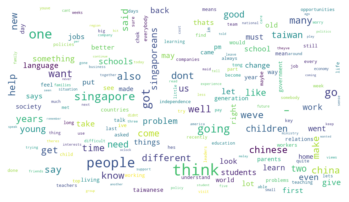

In [106]:
speech_name = "2004_lee_hsien_loong"
### We're using one of the utility function! "read_word_count_file"
fullTermsDict = read_word_count_file(f'{mypath}/word_counts/{speech_name}_unigram_counts.csv')
outputfile = f"./plot/wordcloud_count_unigram_{speech_name}"
makeImage(fullTermsDict, outputfile)


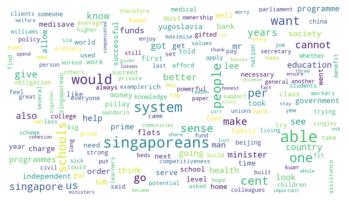

In [107]:
speech_name = "2020_lee_hsien_loong"
### We're using one of the utility function! "read_word_count_file"
fullTermsDict = read_word_count_file(f'{mypath}/word_counts/{speech_name}_unigram_counts.csv')
outputfile = f"./plot/wordcloud_count_unigram_{speech_name}"
makeImage(fullTermsDict, outputfile)


### Exercise 1. Count bigram 

You task is to write a function named ```count_bigrams_from_dataframe``` whose input is dataframe, ```df``` and output is the dictionary of bigrams with their counts. 

Then, can you also save them into file after sorting the bigrams based on their counts? 

(Optional) You may draw word clouds with bigrams as well! 


In [61]:
def count_bigrams_from_dataframe(df):
    
    result_dict = {}                    
    for index, row in df_speech.iterrows():
        text = row['clean_text_2']
        tokens = text.split()
        
        ## write your code 
        
    return result_dict



In [62]:
count_type = 'bigram'

for each_speech in list_of_speeches:
    print(each_speech)
    df_speech = df.query('speech == @each_speech')
    print(df_speech.shape)
    
    ## write your code 
    

1966_lee_kuan_yew
(27, 5)
1991_goh_chok_tong
(435, 5)
2004_lee_hsien_loong
(1186, 5)
2020_lee_hsien_loong
(75, 5)


In [63]:
## solution 
def count_bigrams_from_dataframe(df):
    
    result_dict = {}                    
    for index, row in df_speech.iterrows():
        text = row['clean_text_2']
        tokens = text.split()
        for itr in range(0, len(tokens) - 1):
            token1 = tokens[itr]
            token2 = tokens[itr + 1]
            token = token1 + " " + token2
            try:
                result_dict[token] += 1
            except KeyError:
                result_dict[token] = 1    
    return result_dict


import csv
count_type = 'bigram'

for each_speech in list_of_speeches:
    print(each_speech)
    df_speech = df.query('speech == @each_speech')
    print(df_speech.shape)
    
    result = count_bigrams_from_dataframe(df_speech)
    
    final_result = {}
    sorted_dic = ((k, result[k]) for k in sorted(result, key=result.get, reverse=True))
    for key, value in sorted_dic:
        try:
            final_result[key] += int(value)
        except KeyError:
            final_result[key] = int(value)

    sorted_dic = ((k, result[k]) for k in sorted(result, key=result.get, reverse=True))
    
    with open(f"./word_counts/{each_speech}_{count_type}_counts.csv", 'w') as fp:
        writer = csv.writer(fp, delimiter=',')
        writer.writerows(sorted_dic)


1966_lee_kuan_yew
(27, 5)
1991_goh_chok_tong
(435, 5)
2004_lee_hsien_loong
(1186, 5)
2020_lee_hsien_loong
(75, 5)


# 4. Find representative words by using log odds 

### In this example, we will compare 2004 and 2020 National Day speeches by PM Lee Hsien Loong. 

We will detect unigrams that are over-represented in either 2004 or 2020 speech. 

To do so, we use log-odds ratios with informative Dirichlet priors (Monroe, Colaresi, and Quinn 2008). This method estimates the log-odds ratio of each word between two corpora i and j given the prior frequencies obtained from a back ground corpus. 

This method identifies representative words of a corpus i in comparison with another corpus j and the common corpus (global/background corpus). 

#### We've created a few functions for computing log odds values and finding the representativ words.

```calculate_log_odds_idp(global_counts, counts_i_name, counts_i_dict, counts_j_name, counts_j_dict)``` : it returns the log odds value (```log_odds_z_score```) for each word, which indicates the significance of the word in the corresponding corpus. You should provide background corpus (we call ```global_counts```), two names of the corpora: ```counts_i_name``` and ```counts_j_name``` (for naming the file), and two dictionaries of word counts from each corpus: ```counts_i_dict``` and ```counts_j_dict```. 

```find_discriminative_words(top_words_df, threshold_i, threshold_j, num_i, num_j, mypath)```: This function will filter out those words that appear less than k times in each corpus (`threshold_i` and ```threshold_j```), rank the words based on lod-odds z-scores and select top-N representative words (```num_i```, ```num_j```), and generate a csv file where each row contains (word, log_odds_z_score) for each of the two corpora .  

For details about how to compute log odds z-score, see: "Monroe, B. L.; Colaresi, M. P.; and Quinn, K. M. 2008. Fightin’words: Lexical feature selection and evaluation for identifying the content of political conflict. Political Analysis 16(4):372–403."

In [ ]:
### Let's download ```smt203util.py``` Below code should download the file in the same folder where your jupyter notebook is. 
!wget https://raw.githubusercontent.com/anjisun221/css_codes/main/ay21t1/Lab03_text_analysis/smt203util.py
    

In [63]:
### Let's import all function from smt203util! 
from smt203util import *


0.1

In [46]:
### Getting global word counts (frequency of unigram in Google News datasets)
target_url = "https://raw.githubusercontent.com/anjisun221/css_codes/main/ay21t1/Lab03_text_analysis/1gram_englishall_count.csv"
global_counts = read_word_count_file_online(target_url)
print("The number of unigrams=", len(global_counts))


2280738


In [4]:
### Removing stopwords from the word list and 
stopwords_list = get_stopwords()
global_counts = {k: v for k, v in global_counts.items() if (k not in stopwords_list) and (len(k) > 2)}
print("After excluding stop words: ", len(global_counts))


2278905
Global Corpus Size : 554756723157


#### Let's load word frequency file and create dictionary of word counts for the two speeches!

In [85]:
# counts_i_name = "1966_lee_kuan_yew"
# counts_i_name = "1991_goh_chok_tong"
counts_i_name = "2004_lee_hsien_loong"
# counts_j_name = "2020_lee_hsien_loong"
counts_i = read_word_count_file(f"{mypath}/word_counts/{counts_i_name}_unigram_counts.csv")

### we filter out words that exist in our background corpus
counts_i_dict = {k: v for k, v in counts_i.items() if k in global_counts}


In [86]:
# counts_j_name = "1966_lee_kuan_yew"
# counts_j_name = "1991_goh_chok_tong"
# counts_j_name = "2004_lee_hsien_loong"
counts_j_name = "2020_lee_hsien_loong"
counts_j = read_word_count_file(f"{mypath}/word_counts/{counts_j_name}_unigram_counts.csv")

### we filter out words that exist in our background corpus
counts_j_dict = {k: v for k, v in counts_j.items() if k in global_counts}


In [87]:
### this function will return log-odds values. 
top_words_df = calculate_log_odds_idp(global_counts, counts_i_name, counts_i_dict, counts_j_name, counts_j_dict)


### interpretation lad z-score (log_odds_z_score) 

Consider it as a value that indicate the significance of the word in a corpus. Given that we have two corpora, i and j, the order matters when interpreting this z-score. For corpus i, the lower the z-score, more significant the word is while for corpus j, the higher the z-score, more significant the word is.

The word frequency is also important, if the word frequency is low, those words may not be meaningful. So, we filter words based on the two condition: word frequency and z-score. 

In the below example, 
for corpus i, we will consider words that have lower z-scores and that appear at least twice in the corpus. 

For corpus j, we will consider words that have higher z-scores and that appear at least twice in the corpus. 

Note that, we choose 2 as a threshold for word frequency, but usually it should be much higher if we have larger corpus. Our speech data is small, so we have to choose 2. Normally, we would use 50 or 100 as a minimum number of word frequency. 

In [121]:
### Below shows the representative words of 2004 National Day speech by PM Lee. 
top_words_df[top_words_df[counts_i_name] >= 2].iloc[::-1].head(20)

,word,global_count,2004_lee_hsien_loong,2020_lee_hsien_loong,log_odds_z_score
1518841,national,178377868,11.0,16.0,-0.000364
1115886,hold,59482502,2.0,5.0,-0.000332
754399,crisis,27522377,3.0,5.0,-0.000309
869562,economic,155956183,2.0,4.0,-0.000206
1993224,stood,43873178,2.0,3.0,-0.000156
1966070,space,77355449,2.0,3.0,-0.000146
662608,central,99494834,2.0,3.0,-0.000145
1810883,response,66631194,2.0,2.0,-0.000061
1125288,however,329597894,2.0,0.0,-0.000057
1518759,nation,55917882,4.0,4.0,-0.000056


In [122]:
### Below shows the representative words of 2020 National Day speech by PM Lee. 
top_words_df[top_words_df[counts_j_name] >= 2].head(20)


,word,global_count,2004_lee_hsien_loong,2020_lee_hsien_loong,log_odds_z_score
1936977,singaporeans,59735,36.0,8.0,0.080991
1936971,singapore,6472873,66.0,8.0,0.016101
1218251,jobs,23240011,25.0,3.0,0.003191
1657023,people,394910756,96.0,3.0,0.003163
1094121,help,118062585,41.0,3.0,0.002393
2000272,students,93581046,28.0,2.0,0.001829
716689,come,200277592,39.0,3.0,0.001694
1525334,need,160186128,34.0,3.0,0.001638
1165322,independence,30325925,15.0,2.0,0.001628
1332720,let,128330275,29.0,2.0,0.001601


In [113]:
### Below function will simply help you to print the above table into file, so that we can use it for drawing word cloud. 
### The output of this function is a csv file where each row contains (word, log_odds_z_score) for the two corpora. 
### threshold_i and threshold_j are the threshold of word frequency. 
### num_i and num_j are the number of representative words it will write in file. 
find_discriminative_words(top_words_df, threshold_i=2, threshold_j=2, num_i=20, num_j=20, mypath='.')


## Let's draw WordClouds based on log odds values 

In [114]:
### Create ```plot``` folder 
os.makedirs('plot', exist_ok=True)

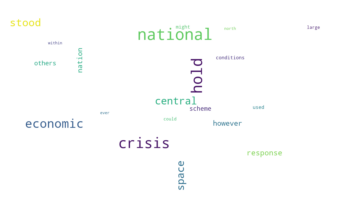

In [119]:
fullTermsDict = read_word_count_file(f"{mypath}/word_counts/wordcloud_word_{counts_i_name}_zscore.csv")
outputfile = f"./plot/wordcloud_log_odds_unigram_{counts_i_name}_compared with_{counts_j_name}"
makeImage(fullTermsDict, outputfile)


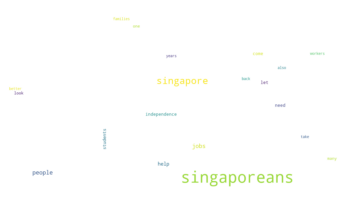

In [120]:
fullTermsDict = read_log_odds_file(f"{mypath}/word_counts/wordcloud_word_{counts_j_name}_zscore.csv")
outputfile = f"./plot/wordcloud_log_odds_unigram_{counts_j_name}_compared_with_{counts_i_name}"
makeImage(fullTermsDict, outputfile)
